In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2016,2017 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause

# Station Plot

Make a station plot, complete with sky cover and weather symbols.

The station plot itself is pretty straightforward, but there is a bit of code to perform the
data-wrangling (hopefully that situation will improve in the future). Certainly, if you have
existing point data in a format you can work with trivially, the station plot will be simple.

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from metpy.calc import reduce_point_density
from metpy.cbook import get_test_data
from metpy.io import metar
from metpy.plots import add_metpy_logo, current_weather, sky_cover, StationPlot

# The setup

First read in the data. We use the metar reader because it simplifies a lot of tasks,
like dealing with separating text and assembling a pandas dataframe
https://thredds.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.html

In [4]:
data = metar.parse_metar_file(get_test_data('metar_20190701_1200.txt', as_file_obj=False))

# Drop rows with missing winds
data = data.dropna(how='any', subset=['wind_direction', 'wind_speed'])

This sample data has *way* too many stations to plot all of them. The number
of stations plotted will be reduced using `reduce_point_density`.

In [5]:
# Set up the map projection
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

# Use the Cartopy map projection to transform station locations to the map and
# then refine the number of stations plotted by setting a 300km radius
point_locs = proj.transform_points(ccrs.PlateCarree(), data['longitude'].values,
                                   data['latitude'].values)
data = data[reduce_point_density(point_locs, 300000.)]

# The payoff

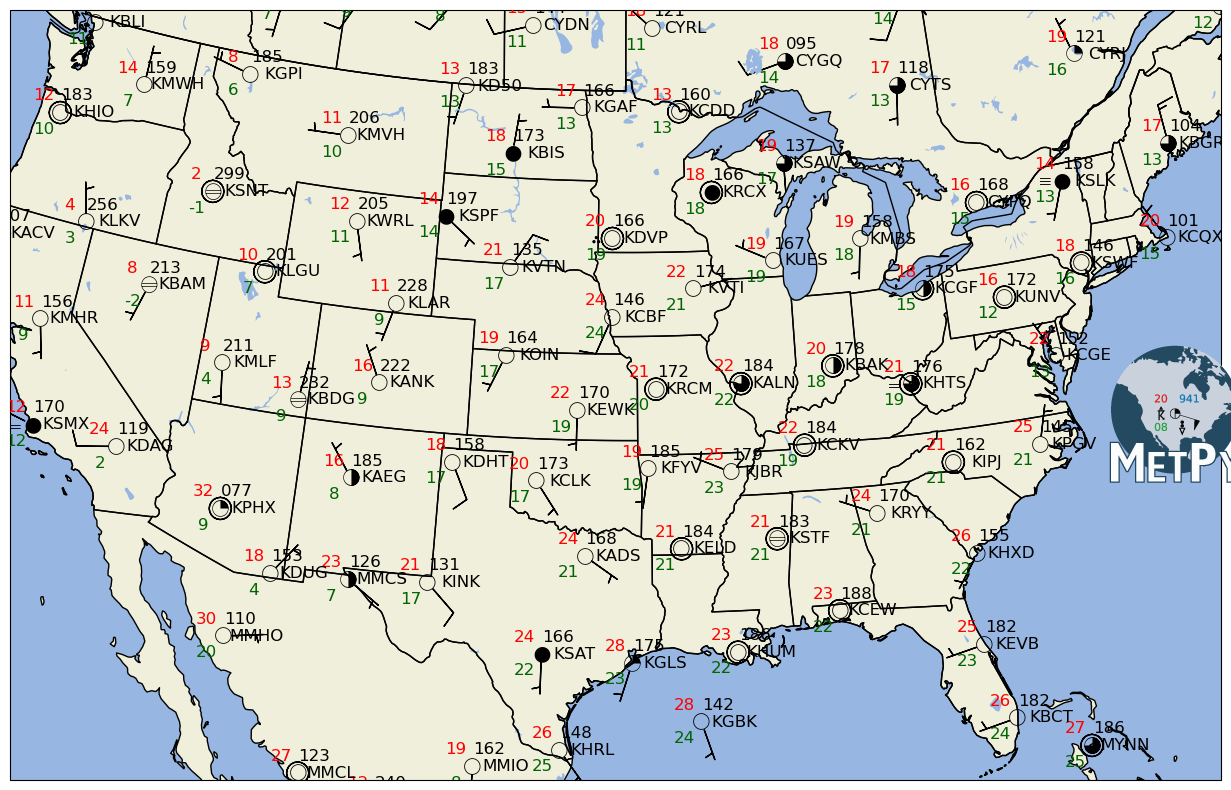

In [6]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

# Set plot bounds
ax.set_extent((-118, -73, 23, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'].values, data['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', data['air_temperature'].values, color='red')
stationplot.plot_parameter('SW', data['dew_point_temperature'].values,
                           color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', data['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', data['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', data['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(data['eastward_wind'].values, data['northward_wind'].values)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
stationplot.plot_text((2, 0), data['station_id'].values)

plt.show()